In [229]:
import os
import sys
sys.path.append('../../')
sys.path.append('../../lib')


import numpy as np
import random
import scipy.signal as ss
import matplotlib
import matplotlib.pyplot as plt

from math import *
from pylab import *
from mpdaf import *

from mpdaf.obj import Cube
from mpdaf.obj import Image
from mpdaf.obj import Spectrum
from mpdaf.obj import WCS
from mpdaf.obj import WaveCoord


from shade import shade_main,parameters,detection,array_tools,preprocessing,postprocessing,function_Image
reload(shade_main)
reload(parameters)
reload(detection)
reload(array_tools)
reload(preprocessing)
reload(postprocessing)
reload(function_Image)
%matplotlib inline
rcParams['image.cmap']='coolwarm'
rcParams['image.origin']='lower'
rcParams['image.interpolation']='nearest'

In [223]:
listID=[43]#,43, 92, 95, 139]

cube=Cube('/home/data/MUSE/v1.30/DATACUBE-HDFS-v1.34.fits')

In [224]:
### choix des paramètres, 
# sim=False : il ne s'agit pas d'une source simu, on permet
# lmbdaShift : variation max dans la famille de spectres de tests créés (on va de -lmbdaShift à + lmbdaShift)
# LW : demi-largeur de la zone étudié en lmbda
# SW : demi-largeur de la zone étudié en spatial
params=parameters.Params(sim=False,lmbdaShift=7,LW=15,SW=20)

### creation de l'objet méthode à partir de la liste d'ID, cela permet de construire des sources plus grandes que celles obtenues dans le catalogue
shade1=shade_main.SHADE(listID=listID,params=params,catalog='/home/data/MUSE/HDFS/MasterCatalogue-1p24.fits',cube=cube) 

#preprocessing avec parametrisation : ici,on fait la soustraction du continu par filtre median, et on force le preprocessing
paramsPreProcess=parameters.ParamsPreProcess(methodRC='medfilt',forceProcess=True)
shade1.preprocess(paramsPreProcess=paramsPreProcess)


In [225]:
### Detection
shade1.detect()

In [226]:
### PostProcess
shade1.postprocess()

<matplotlib.colorbar.Colorbar instance at 0x7f78b0515f80>

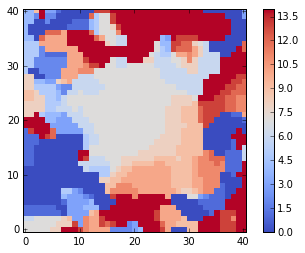

In [230]:
plt.imshow(shade1.listSources[0].images['DET_INDEX_ALL'].data)
plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x7f78b0376bd8>

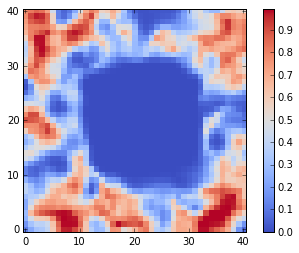

In [231]:
plt.imshow(shade1.listSources[0].images['DET_STAT'].data)
plt.colorbar()